# Analysis data with all vector

In [8]:
# Import the libraries
import tensorflow as tf
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt  # for 畫圖用
import pandas as pd# load and evaluate a saved model
from numpy import loadtxt
from tensorflow.keras.models import load_model,save_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation,Flatten, LSTM, TimeDistributed, RepeatVector,GRU, Input, ConvLSTM2D, Bidirectional,BatchNormalization
from tensorflow.keras import Input
#from tensorflow.keras.layers.normalization import BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,Nadam

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error
import math
import json
from IPython.core.pylabtools import figsize

figsize(15, 7) 

### Utils

In [9]:
def read_data(path,o_dtname="Datetime",c_dtname = 'datetime',names=None,skiprows=None):
    df = pd.read_csv(path, sep=',', 
                     parse_dates={c_dtname:[o_dtname]}, 
                     infer_datetime_format=True, 
                     low_memory=False, 
                     na_values=['nan','?'], 
                     index_col=c_dtname,
                     names=names,
                    skiprows=skiprows)

    #df = df.reindex(index=df.index[:,:-1])
    print(df.isnull().sum())
    # filling nan with mean in any columns
    #for j in range(df.shape[1]):        
        #df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())
        
    #df.iloc[:,4:] = df.iloc[:,4:]*100
    #another sanity check to make sure that there are not more any nan
    #print(df.isnull().sum())
    #print(df.head())
    return df
#draw_trend
def draw_trend(df,groups,bound=200):
    #figsize(15,10) 
    
    anomly_df = df.copy()
    anomly_df[anomly_df>0] = np.nan
    
    i=1
    Values = df.values
    Anomaly = anomly_df.values
    cols = groups
    
    for group in groups:
        plt.subplot(len(cols), 1, i)
        plt.plot(df.iloc[:].index,Values[:bound, group],linewidth=3)
        plt.plot(df.iloc[:].index,Anomaly[:bound, group],color='red',linewidth=8)
        plt.title(df.columns[group], loc='right')
        plt.grid()
        plt.xticks(rotation=45)
        #plt.xticks(range(0,4020,20))
        i += 1
    plt.show()
    print('\n')

def draw_trend_resample(df,groups,resample_freq,bound=200):
    #figsize(15,10) 
    i=1
    Values = df.resample(resample_freq).mean().values
    cols = groups
    for group in groups:
        plt.subplot(len(cols), 1, i)
        plt.plot(Values[:bound, group],linewidth=3)
        #plt.xticks(range(0,bound+10,10))
        plt.title(df.columns[group]+' resample-{}'.format(resample_freq), y=0.80, loc='right')
        i += 1
    plt.tight_layout()
    plt.show()
    
    print('\n')
#draw_corr
def show_corr(df,group,method):
    plt.matshow(df.iloc[:,group].corr(method=method),vmax=1,vmin=-1,cmap='PRGn')
    plt.title('{}_original'.format(method), size=15)
    plt.xticks(range(len(group)),labels=map(str,group))
    plt.yticks(range(len(group)),labels=map(str,group))
    plt.colorbar()
    plt.show()
    
def show_corr_resample(df,group,resample_freq):
    plt.matshow(df.resample(resample_freq).mean().iloc[:,group].corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
    plt.title('Spearman_resample-{}'.format(resample_freq), size=15)
    plt.xticks(range(len(group)),labels=map(str,group))
    plt.yticks(range(len(group)),labels=map(str,group))
    plt.colorbar()
    plt.show()
    

In [10]:
from scipy import stats
def gen_dataset(data,x_window_size,y_window_size):
    X_train = []   #預測點的前 60 天的資料
    y_train = []   #預測點
    for i in range(x_window_size, data.shape[0]-y_window_size,y_window_size):
        X_train.append(data.iloc[i-x_window_size:i, :-1].values)
        
        if np.sum(data.iloc[i-x_window_size:i, -1].values) >= 1:
            y_train.append(1)
        else:
            y_train.append(0)

    X_train, y_train = np.array(X_train), np.array(y_train)  # 轉成numpy array的格式，以利輸入 RNN
    
    #X_train = np.reshape(X_train, (X_train.shape[0], x_window_size,data.shape[1] ))

    """if y_window_size == 1:
        y_train = np.reshape(y_train,(y_train.shape[0], y_train.shape[2]))
    else:
        y_train = np.reshape(y_train,(y_train.shape[0],y_window_size,y_train.shape[2]))"""
        
    print("Gen data info:")
    print("X_data_shape:{}".format(X_train.shape))
    print("y_data_shape:{}".format(y_train.shape))
    print("\n")
          
    return X_train,y_train

def data_scaling(data,X_win_size,y_win_size,mode='robust'):
    
    assert mode == 'robust' or mode == 'minmax','Wrong mode name'
    print("Mode:{}\n".format(mode))
    
    #Record training data index
    data_index = data.shape[0]
   
    # Feature Scaling
    from sklearn.preprocessing import MinMaxScaler,RobustScaler
    if mode =='robust':
         #RobustScaler
        scaler = RobustScaler()
        data[list(data.columns)[:4]] = scaler.fit_transform(data[list(data.columns)[:4]])     
    elif mode == 'minmax':        
        #MinMaxScaler
        scaler = MinMaxScaler()
        data.iloc[:,[0,1,2,3]] = scaler.fit_transform(data.iloc[:,[0,1,2,3]])     
    
    
    #generate dataset
    data_X,data_y = gen_dataset(data,X_win_size,y_win_size)
    
    return data_X,data_y,scaler,data,scaler.get_params()


In [12]:
all_vector_path = "./Dataset/OPTIdata/6v_1029.csv"
data5v_with_diskio = "./Dataset/OPTIdata/5v_180_1029.csv"
data6v_with_diskio = "./Dataset/OPTIdata/6v_180_1029.csv"

df = read_data(all_vector_path,o_dtname="datetime",c_dtname = 'dt')
df

host     0
name     0
value    0
dtype: int64


,host,name,value
dt,,,
2021-10-29 14:56:00,TWKHH01OPTIPW6V,Memory used (%),81.6550
2021-10-29 14:56:00,TWKHH01OPTIPW6V,Free disk space on D: (%),84.7834
2021-10-29 14:56:00,TWKHH01OPTIPW6V,Free disk space on C: (%),16.2152
2021-10-29 14:56:00,TWKHH01OPTIPW6V,Disk (0 C:) - Current Disk Queue Length,0.0000
2021-10-29 14:56:00,TWKHH01OPTIPW6V,CPU utilization (%),88.7102
...,...,...,...
2021-10-19 15:02:00,TWKHH01OPTIPW6V,CPU utilization (%),76.1676
2021-10-19 14:59:00,TWKHH01OPTIPW6V,Memory used (%),73.9515
2021-10-19 14:59:00,TWKHH01OPTIPW6V,Free disk space on D: (%),86.5478


In [54]:
from IPython.display import clear_output

col = np.unique(df.name.values)
df_list = []
for i,col_name in enumerate(col):
    
    filename = col_name.replace("."," ")
    filename = filename.replace("/"," ")
    filename = filename.replace("%","percent ")
    filename = filename.replace(":"," disk")
    print(col_name)
    
    tmp_df = df[df["name"]==col_name].drop(["host","name"],axis=1)
    tmp_df = tmp_df.rename(columns={'value':col_name })
    df_list.append(tmp_df)
    plt.plot(tmp_df[col_name],label="value")
    plt.title("6V-{}".format(col_name))
    plt.legend()
    #Server_mantain/Zabbix_Online_detection/Dataset/OPTIdata/all_vector_analysis
    plt.savefig("./Dataset/OPTIdata/all_vector_analysis/{}-6V-all_vector.jpg".format(filename))
    plt.show()
    clear_output(wait=True)
    
concat_df = pd.concat(df_list,axis=1)
concat_df.fillna(method='ffill', inplace=True)
concat_df.fillna(method='bfill', inplace=True)



AttributeError: 'list' object has no attribute 'columns'

In [64]:
concat_df

,CPU utilization (%),Disk (0 C:) - % Disk saturation,Disk (0 C:) - % Idle Time,Disk (0 C:) - Average Disk Bytes Read,Disk (0 C:) - Average Disk Bytes Total,Disk (0 C:) - Average Disk Bytes Write,Disk (0 C:) - Avg. Disk Queue Length,Disk (0 C:) - Avg. Disk sec/Read (Latency),Disk (0 C:) - Avg. Disk sec/Transfer (Latency),Disk (0 C:) - Avg. Disk sec/Write (Latency),...,Disk (1 D:) - Avg. Disk sec/Read (Latency),Disk (1 D:) - Avg. Disk sec/Transfer (Latency),Disk (1 D:) - Avg. Disk sec/Write (Latency),Disk (1 D:) - Current Disk Queue Length,Free disk space on C: (%),Free disk space on D: (%),Memory used (%),Processor load (1 min average),Processor load (15 min average),Processor load (5 min average)
dt,,,,,,,,,,,,,,,,,,,,,
2021-10-19 14:59:00,74.5207,-0.0025,99.8885,0.0,0.0,4778.6667,0.0000,0.0,0.002,0.0,...,0.0,0.000,0.0000,0.0,16.5992,86.5478,73.9515,0.0194,0.0603,0.1286
2021-10-19 15:02:00,76.1676,-0.0025,99.8885,0.0,0.0,4778.6667,0.0000,0.0,0.002,0.0,...,0.0,0.000,0.0000,0.0,16.5981,86.5474,74.2101,0.0194,0.0603,0.1286
2021-10-19 15:05:00,74.3353,-0.0025,99.8885,0.0,0.0,4778.6667,0.0000,0.0,0.002,0.0,...,0.0,0.000,0.0000,0.0,16.5983,86.5471,72.5727,0.0194,0.0603,0.1286
2021-10-19 15:08:00,76.1761,-0.0025,99.8885,0.0,0.0,4778.6667,0.0000,0.0,0.002,0.0,...,0.0,0.000,0.0000,0.0,16.5958,86.5468,72.6675,0.0194,0.0603,0.1286
2021-10-19 15:11:00,76.0155,-0.0025,99.8885,0.0,0.0,4778.6667,0.0000,0.0,0.002,0.0,...,0.0,0.000,0.0000,0.0,16.5937,86.5464,72.8638,0.0194,0.0603,0.1286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-29 14:52:00,76.9816,0.0026,99.8698,0.0,0.0,16384.0000,0.0055,0.0,0.003,0.0,...,0.0,0.001,0.0035,0.0,16.2146,84.7842,75.6086,0.0931,0.0172,0.0336
2021-10-29 14:53:00,88.1873,0.0026,99.8698,0.0,0.0,16384.0000,0.0055,0.0,0.003,0.0,...,0.0,0.001,0.0035,0.0,16.2135,84.7838,78.7106,0.1306,0.0253,0.0531
2021-10-29 14:54:00,88.1873,0.0026,99.8698,0.0,0.0,16384.0000,0.0055,0.0,0.003,0.0,...,0.0,0.001,0.0035,0.0,16.2135,84.7838,78.7106,0.1319,0.0339,0.0792


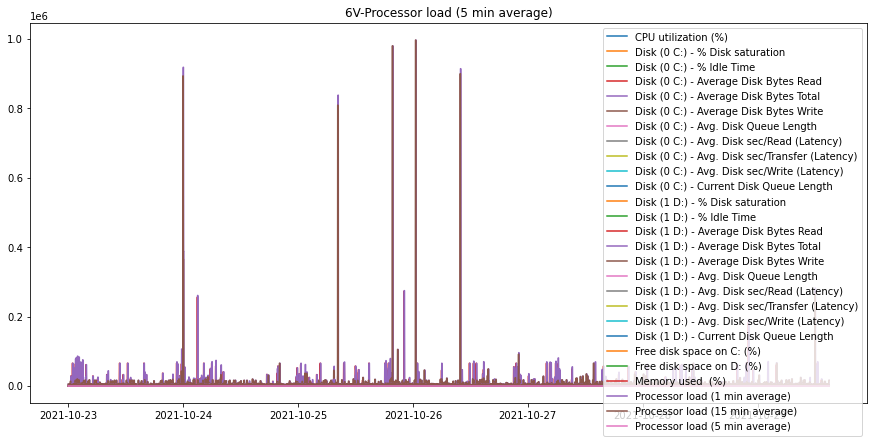

In [72]:
for name in concat_df.columns[:]:
    
    filename = name.replace("."," ")
    filename = filename.replace("/"," ")
    filename = filename.replace("%","percent ")
    filename = filename.replace(":"," disk")
    plt.plot(concat_df[name].loc['2021-10-23':],label=name)
    plt.title("6V-{}".format(name))
    plt.legend()
    #Server_mantain/Zabbix_Online_detection/Dataset/OPTIdata/all_vector_analysis
    #plt.savefig("./Dataset/OPTIdata/all_vector_analysis/{}-6V-all_vector.jpg".format(filename))
    clear_output(wait=True)
    #plt.show()

Memory used  (%)                           0
CPU utilization (%)                        0
Disk (0 C:) - Current Disk Queue Length    0
Disk (1 D:) - Current Disk Queue Length    0
Label                                      0
dtype: int64
                     Memory used  (%)  CPU utilization (%)  \
dt                                                           
2021-06-20 09:00:00         28.566922            39.851956   
2021-06-20 10:00:00         28.828743            37.081960   
2021-06-20 11:00:00         27.201200            37.182560   
2021-06-20 12:00:00         28.462700            31.697695   
2021-06-20 13:00:00         27.996105            43.175465   

                     Disk (0 C:) - Current Disk Queue Length  \
dt                                                             
2021-06-20 09:00:00                                      0.0   
2021-06-20 10:00:00                                      0.0   
2021-06-20 11:00:00                                      0.0   
2021-06

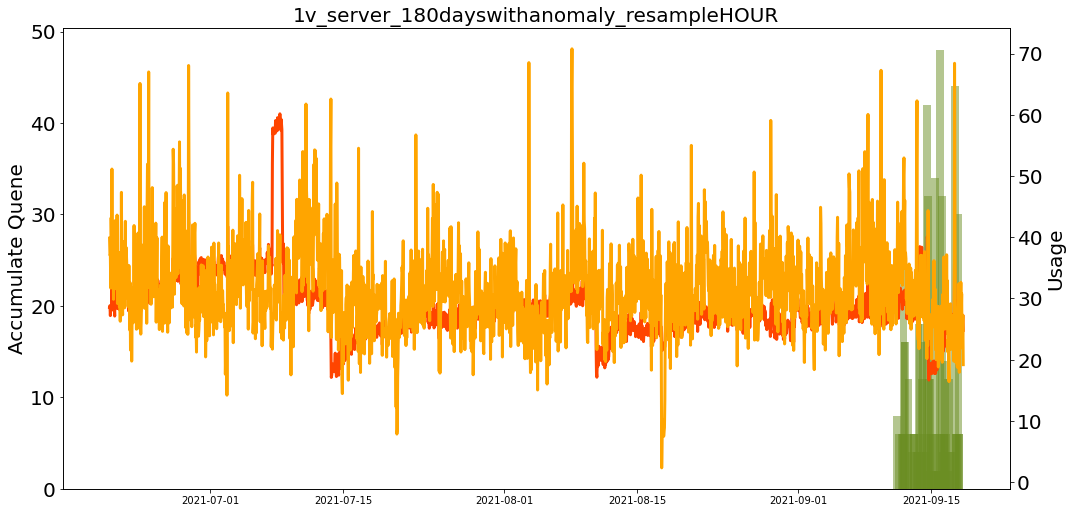

Memory used  (%)                           0
CPU utilization (%)                        0
Disk (0 C:) - Current Disk Queue Length    0
Disk (1 D:) - Current Disk Queue Length    0
Label                                      0
dtype: int64
                     Memory used  (%)  CPU utilization (%)  \
dt                                                           
2021-06-20 09:00:00         14.113606             1.207067   
2021-06-20 10:00:00         14.095523             1.461820   
2021-06-20 11:00:00         14.128880             1.280370   
2021-06-20 12:00:00         14.089222             1.241520   
2021-06-20 13:00:00         14.128913             1.258165   

                     Disk (0 C:) - Current Disk Queue Length  \
dt                                                             
2021-06-20 09:00:00                                      0.0   
2021-06-20 10:00:00                                      0.0   
2021-06-20 11:00:00                                      0.0   
2021-06

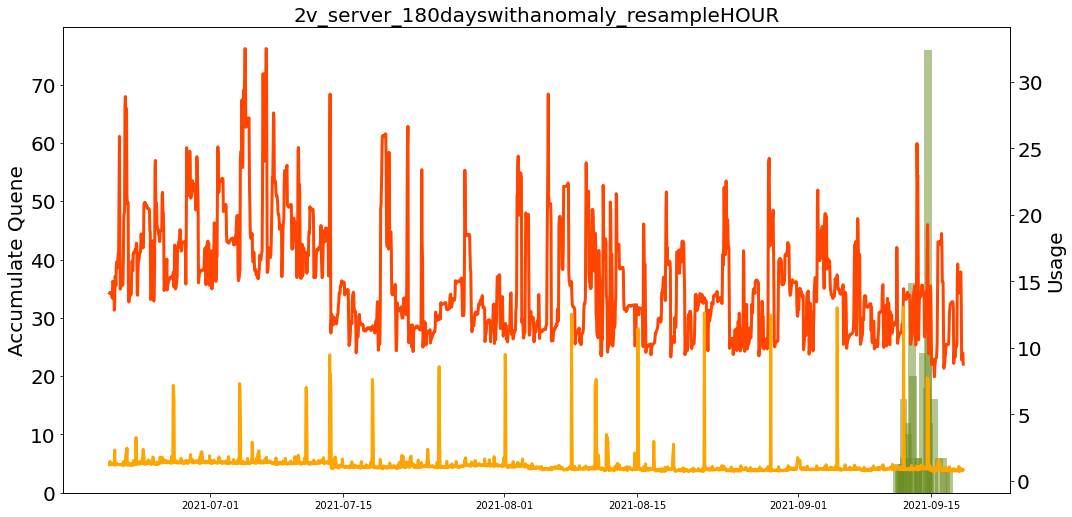

Memory used  (%)                           0
CPU utilization (%)                        0
Disk (0 C:) - Current Disk Queue Length    0
Disk (1 D:) - Current Disk Queue Length    0
Label                                      0
dtype: int64
                     Memory used  (%)  CPU utilization (%)  \
dt                                                           
2021-06-20 09:00:00         19.636733             8.287033   
2021-06-20 10:00:00         20.635300            10.620855   
2021-06-20 11:00:00         19.013268             8.150290   
2021-06-20 12:00:00         20.051527             6.334245   
2021-06-20 13:00:00         19.982570             8.900310   

                     Disk (0 C:) - Current Disk Queue Length  \
dt                                                             
2021-06-20 09:00:00                                      0.0   
2021-06-20 10:00:00                                      0.0   
2021-06-20 11:00:00                                      0.0   
2021-06

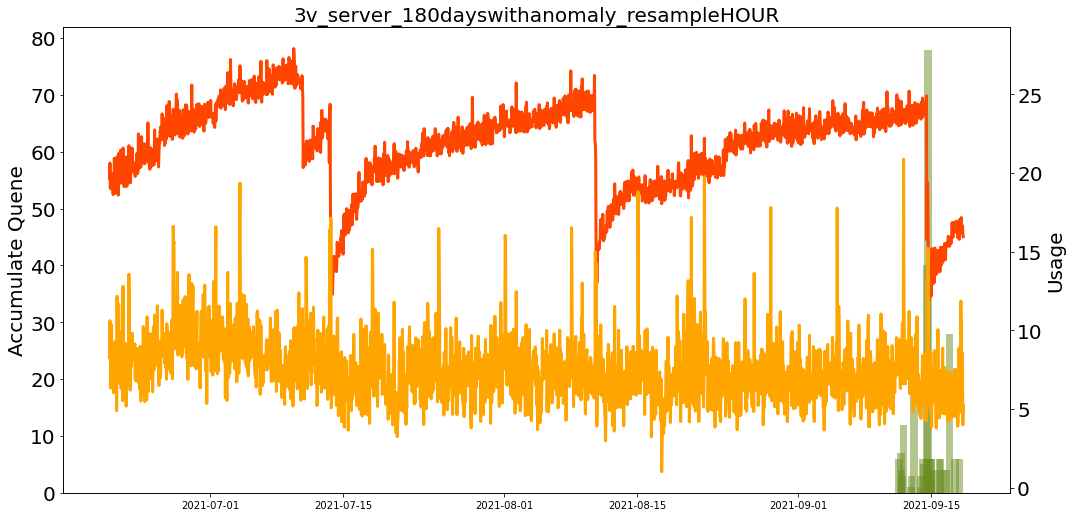

Memory used  (%)                           0
CPU utilization (%)                        0
Disk (0 C:) - Current Disk Queue Length    0
Disk (1 D:) - Current Disk Queue Length    0
Label                                      0
dtype: int64
                     Memory used  (%)  CPU utilization (%)  \
dt                                                           
2021-06-20 09:00:00         12.935383             1.118944   
2021-06-20 10:00:00         12.926137             1.078355   
2021-06-20 11:00:00         12.936700             1.078200   
2021-06-20 12:00:00         12.991245             1.120410   
2021-06-20 13:00:00         13.001953             1.094930   

                     Disk (0 C:) - Current Disk Queue Length  \
dt                                                             
2021-06-20 09:00:00                                      0.0   
2021-06-20 10:00:00                                      0.0   
2021-06-20 11:00:00                                      0.0   
2021-06

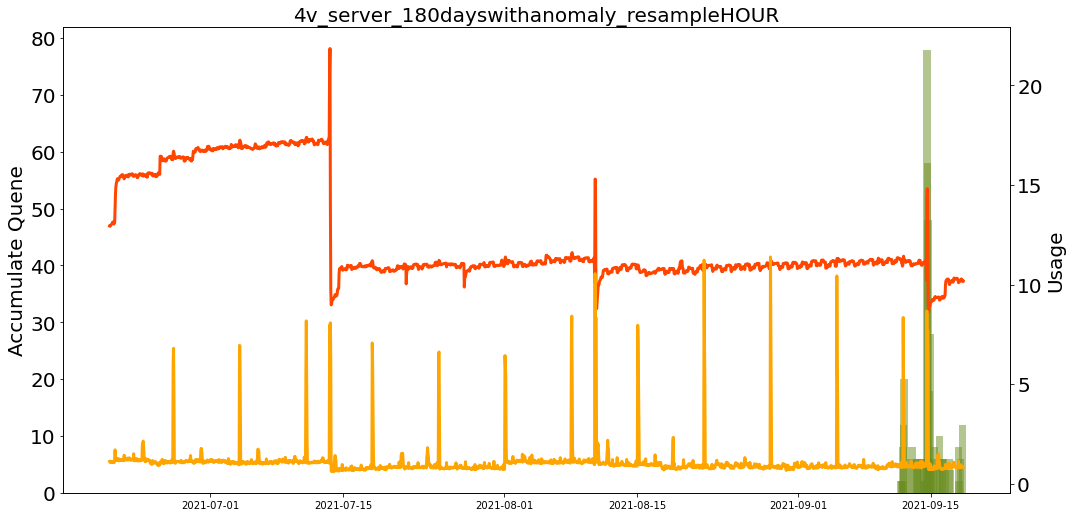

Memory used  (%)                           0
CPU utilization (%)                        0
Disk (0 C:) - Current Disk Queue Length    0
Disk (1 D:) - Current Disk Queue Length    0
Label                                      0
dtype: int64
                     Memory used  (%)  CPU utilization (%)  \
dt                                                           
2021-06-20 09:00:00         15.324467             4.633911   
2021-06-20 10:00:00         14.341952             8.398715   
2021-06-20 11:00:00         14.190687             6.687040   
2021-06-20 12:00:00         15.669625             9.170250   
2021-06-20 13:00:00         14.167898             6.942100   

                     Disk (0 C:) - Current Disk Queue Length  \
dt                                                             
2021-06-20 09:00:00                                      0.0   
2021-06-20 10:00:00                                      0.0   
2021-06-20 11:00:00                                      0.0   
2021-06

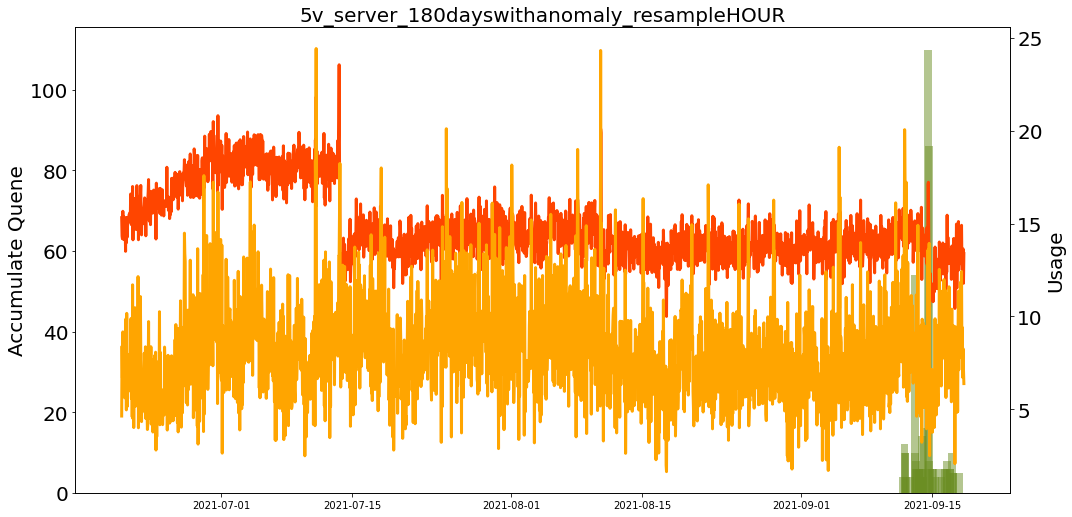

Memory used  (%)                           0
CPU utilization (%)                        0
Disk (0 C:) - Current Disk Queue Length    0
Disk (1 D:) - Current Disk Queue Length    0
Label                                      0
dtype: int64
                     Memory used  (%)  CPU utilization (%)  \
dt                                                           
2021-06-20 10:00:00         68.997344            80.346878   
2021-06-20 11:00:00         69.694937            77.582825   
2021-06-20 12:00:00         62.959915            77.360200   
2021-06-20 13:00:00         64.110505            78.613925   
2021-06-20 14:00:00         63.443767            76.853580   

                     Disk (0 C:) - Current Disk Queue Length  \
dt                                                             
2021-06-20 10:00:00                                      0.0   
2021-06-20 11:00:00                                      0.0   
2021-06-20 12:00:00                                      0.0   
2021-06

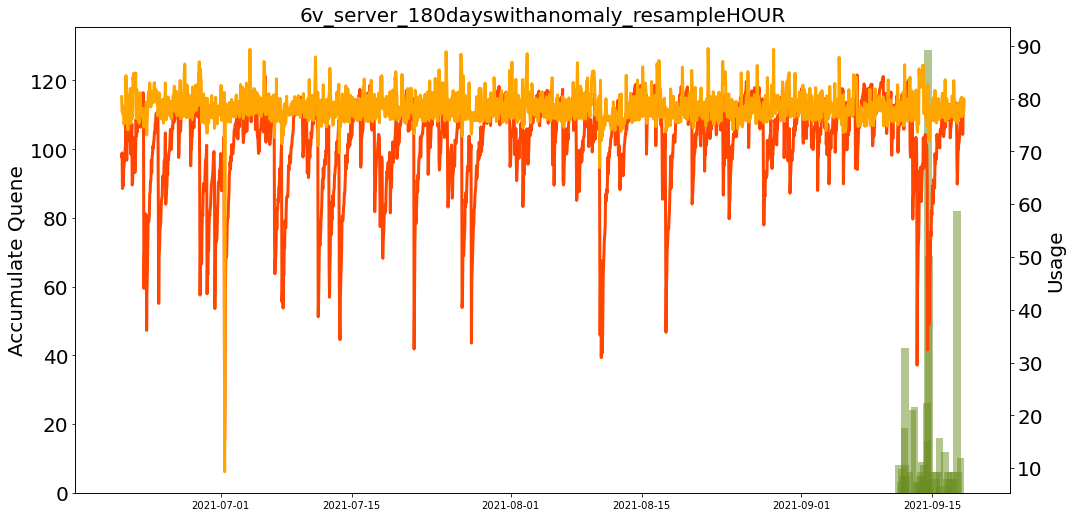

In [86]:
#Usage vs. Quene mean

for path in glob.glob("./Dataset/OPTIdata/pre_process_withlabel/*180dayswithanomaly_resampleHOUR_quene_sum.csv"):
    figsize(15,7)
    df = read_data(path,
              o_dtname="Datetime",
              c_dtname='dt')
    df = df.loc[:,:]
    server_name = path.split("\\")[-1].split("_")[0]
    print(df.head())
    fig, ax1 = plt.subplots()
    
    
    
    ax2 = ax1.twinx()
    
    
    
    ax1.set_ylabel("Accumulate Quene",fontsize=20)
    ax1.bar(df["Disk (0 C:) - Current Disk Queue Length"].index.values,
            df["Disk (0 C:) - Current Disk Queue Length"].values,
            label="Number of Accumulate Quene",
            zorder=1,
            alpha = 0.5,
            color='olivedrab'
           )
    ax1.tick_params(axis='y',labelsize=20)
    
    ax2.set_ylabel("Usage",fontsize=20)
    ax2.plot(df["Memory used  (%)"].index.values,
             df["Memory used  (%)"].values,
             label="Memory used  (%)",
             zorder=10,
            linewidth=3,
            color='orangered')
    ax2.plot(df["CPU utilization (%)"].index.values,
             df["CPU utilization (%)"].values,
             label="CPU utilization (%)",
             zorder=10,
            linewidth=3,
            color='orange')
    #ax1.legend(fontsize='xx-large')
    
    ax2.tick_params(axis='y',labelsize=20)
    ax2.tick_params(axis='x',labelsize=20)
    
    fig.tight_layout()
    plt.title("{}_server_180dayswithanomaly_resampleHOUR".format(server_name),fontsize=20)
    #plt.xtick(fontsize=20)
    plt.xlabel("Datetime",fontsize=10)
    
    plt.savefig(os.path.join(root_path,"OPTIdata","pre_process_withlabel","{}_server_180dayswithanomaly_resampleHOUR_line_and_bar.jpg".format(server_name)),bbox_inches="tight")
    plt.show()
    